In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import ipywidgets as widgets
from IPython.display import display, clear_output

plt.style.use('fivethirtyeight')
%matplotlib widget

# Color convention for the course:
# Blue (solid): Data and true distributions
# Red (dashed): Approximations (CLT, delta method, etc.)
COLOR_DATA = 'steelblue'
COLOR_APPROX = 'firebrick'
COLOR_TRUE = 'black'

# --- Likelihood demo setup (used later in lecture) ---

def log_likelihood_exp(lam, data):
    """Log-likelihood for exponential model."""
    n = len(data)
    if lam <= 0:
        return -np.inf
    return n * np.log(lam) - lam * np.sum(data)

def create_likelihood_demo(interarrivals, lambda_true):
    """Create the interactive likelihood demo. Returns (fig, update_func, widgets)."""
    fig_demo, ax_demo = plt.subplots(figsize=(10, 6))
    
    def update_likelihood(n, seed, show_ratio):
        ax_demo.clear()
        
        # Generate sample
        np.random.seed(seed)
        sample = np.random.choice(interarrivals, size=n, replace=True)
        lambda_hat = 1 / np.mean(sample)
        
        # Compute normalized log-likelihood (divided by n)
        lambda_grid = np.linspace(0.015, 0.065, 200)
        loglik_normalized = np.array([log_likelihood_exp(lam, sample) / n for lam in lambda_grid])
        
        # Expected log-likelihood
        expected_loglik = np.array([np.log(lam) - lam / lambda_true for lam in lambda_grid])
        
        # If showing ratio, subtract value at true lambda
        if show_ratio:
            ref_sample = log_likelihood_exp(lambda_true, sample) / n
            ref_expected = np.log(lambda_true) - 1
            loglik_normalized = loglik_normalized - ref_sample
            expected_loglik = expected_loglik - ref_expected
            ylabel = r'$[\ell(\lambda) - \ell(\lambda_0)]/n$'
        else:
            ylabel = r'$\ell(\lambda) / n$'
        
        ax_demo.plot(lambda_grid, loglik_normalized, color=COLOR_DATA, linewidth=2.5,
                     label=f'Sample log-lik / n')
        ax_demo.plot(lambda_grid, expected_loglik, '--', color=COLOR_APPROX, linewidth=2,
                     label=r'$M(\lambda)$' + (' $ - M(\lambda_0)$' if show_ratio else ''))
        
        ax_demo.axvline(lambda_hat, color=COLOR_DATA, linestyle=':', linewidth=1.5, alpha=0.7,
                        label=f'MLE: {lambda_hat:.4f}')
        ax_demo.axvline(lambda_true, color=COLOR_TRUE, linestyle='--', linewidth=1.5,
                        label=f'True $\\lambda_0$: {lambda_true:.4f}')
        
        if show_ratio:
            ax_demo.axhline(0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
        
        ax_demo.set_xlabel(r'$\lambda$', fontsize=12)
        ax_demo.set_ylabel(ylabel, fontsize=12)
        ax_demo.set_title(f'Normalized Log-Likelihood (n = {n})', fontsize=14, fontweight='bold')
        ax_demo.legend(loc='lower left', fontsize=9)
        
        ymin = expected_loglik.min() - 0.2
        ymax = expected_loglik.max() + 0.2
        ax_demo.set_ylim(ymin, ymax)
        
        fig_demo.canvas.draw_idle()
    
    # Create widgets
    n_slider = widgets.IntSlider(value=50, min=10, max=500, step=10, description='Sample size n:')
    resample_button = widgets.Button(description='Resample', button_style='primary')
    ratio_toggle = widgets.ToggleButton(value=False, description='Subtract at λ₀')
    
    seed_state = {'value': 42}
    
    def refresh():
        update_likelihood(n_slider.value, seed_state['value'], ratio_toggle.value)
    
    def on_resample(b):
        seed_state['value'] += 1
        refresh()
    
    resample_button.on_click(on_resample)
    n_slider.observe(lambda change: refresh(), names='value')
    ratio_toggle.observe(lambda change: refresh(), names='value')
    
    widget_box = widgets.HBox([n_slider, resample_button, ratio_toggle])
    
    return fig_demo, refresh, widget_box

# Lecture 3: The Likelihood Function and the Score

**Data 145, Spring 2026: Evidence and Uncertainty**  
**Instructors:** Ani Adhikari, William Fithian

---

**Please run the code cell above before you start reading.**

---

## Probability vs. Statistics

In your probability courses (Data 140 or EECS 126), you learned to work *forward* from distributions to data:

> If $X_1, \ldots, X_n \stackrel{\text{iid}}{\sim} \text{Exponential}(\lambda)$ with $\lambda = 0.04$, what is the distribution of $\bar{X}_n$?

This is a **probability** question. We know the distribution; we want to understand what the data will look like.

**Statistics** works in the opposite direction — *backward* from data to distributions:

> We observed earthquake interarrival times $X_1, \ldots, X_n$. If we assume they're i.i.d. $\text{Exponential}(\lambda)$, what can we say about $\lambda$?

The key difference: **the analyst doesn't know $\lambda$**. This constraint — what the analyst knows and doesn't know — shapes everything we do in statistics.

### The Analyst's Perspective

Throughout this course, we'll frequently adopt the **analyst's perspective**: imagining ourselves as someone who has access to data but not to the true parameter values. This perspective is essential because:

1. **Estimators must be computable from data**: An estimator $\hat{\theta}(X)$ must be a function of the data alone. We can't use the true $\theta$ in our formula — if we knew $\theta$, we wouldn't need to estimate it!

2. **Uncertainty is about the limits of the analyst's knowledge**: Because the estimator is random, and the parameter is unknown, the analyst still doesn't know the true value of the parameter after seeing data.

3. **Good methods work across parameter values**: A good estimation procedure should work well for a wide range of different true values that $\theta$ might take.

---

## Statistical Models

A **statistical model** is a set of candidate probability distributions that might have generated the data. The analyst assumes the true distribution belongs to this set but doesn't know which one.

### Parametric Models

In a **parametric model**, the distribution is known up to a finite number of unknown parameters. We write:

$$X_1, \ldots, X_n \stackrel{\text{iid}}{\sim} f_\theta$$

where $f_\theta$ is a density or probability mass function indexed by parameter $\theta$ in some *parameter space* $\Theta$.

**Examples:**
- $X_i \stackrel{\text{iid}}{\sim} \text{Exponential}(\lambda)$, with $\lambda > 0$ unknown (Lecture 1 earthquake model)
- $X_i \stackrel{\text{iid}}{\sim} N(\mu, \sigma^2)$ with $\mu$ unknown, $\sigma^2$ known
- $X_i \stackrel{\text{iid}}{\sim} \text{Bernoulli}(p)$ with $p \in (0,1)$ unknown

### Nonparametric Models

In a **nonparametric model**, we don't assume the distribution has a particular parametric form:

$$X_1, \ldots, X_n \stackrel{\text{iid}}{\sim} F$$

where $F$ is an unknown CDF.

**Example:** In Lecture 1, the "just count" estimator $\hat{p}_{\text{Obs}} = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(X_i \le 7)$ doesn't require the exponential assumption — it works under the nonparametric model.

### Important Notes

1. **Parametric models make stronger assumptions.** This can be powerful (more precision, as we saw in Lecture 1) but also risky (what if the assumptions are wrong?).

2. **"Nonparametric" doesn't mean "assumption-free."** Even $X_i \stackrel{\text{iid}}{\sim} F$ assumes independence and identical distributions — both are strong assumptions!

3. **Today we focus on single-parameter models** where the distribution is known up to one real number $\theta$.

---

## Notation

Let's establish notation we'll use throughout the course:

| Symbol | Meaning |
|--------|--------|
| $\theta$ | Generic parameter value (may or may not be the "true" value) |
| $\theta_0$ | The true parameter value that generated the data |
| $\Theta$ | Parameter space (set of possible values) |
| $X$ | The data (random variables), sometimes $X = (X_1, \ldots, X_n)$ |
| $x$ | Possible value $X$ could take, sometimes $x = (x_1, \ldots, x_n)$ |
| $f_\theta(x)$ | Density/pmf of a single observation at $\theta$ |
| $\hat{\theta}$ | An estimator of $\theta$ (a function of data) |

**Convention:** Capital letters for random variables, lowercase for realized values. We write $\hat{\theta}$ rather than $\hat{\theta}(X)$ when the dependence on data is clear from context.

---

## Point Estimation

The simplest inference problem is **point estimation**: making our best guess of the true parameter value (or some function of it) after observing data.

### Estimators and Their Properties

An **estimator** $\hat{\theta} = \hat{\theta}(X)$ is a function of the data that produces a guess for $\theta$. Key point: **the analyst must be able to compute $\hat{\theta}$ without knowing $\theta_0$.**

Since $\hat{\theta}$ is a function of random data, it has a **sampling distribution**. Different samples give different estimates. Good estimators have sampling distributions that are:
- Centered near the true value $\theta_0$
- Concentrated (low variance)

The standard deviation of an estimator is called its **standard error**.

### Consistency

We say $\hat{\theta}_n$ is **consistent** for $\theta_0$ if $\hat{\theta}_n \stackrel{P}{\to} \theta_0$ as $n \to \infty$.

In words: as we collect more data, our estimate gets arbitrarily close to the truth with high probability.

### Asymptotic Normality

Many good estimators are **asymptotically normal**, with errors that shrink like $1/\sqrt{n}$:

$$\sqrt{n}(\hat{\theta}_n - \theta_0) \stackrel{d}{\to} N(0, \sigma^2)$$

Equivalently, for large $n$: $\hat{\theta}_n \approx N(\theta_0, \sigma^2/n)$.

**Question:** If $\hat{\theta}_n$ is asymptotically normal with this form, is it consistent? Why?

*Answer:* Yes! By Slutsky's theorem (Lecture 2), $\hat{\theta}_n - \theta_0 = \frac{1}{\sqrt{n}} \cdot \sqrt{n}(\hat{\theta}_n - \theta_0) \stackrel{d}{\to} 0$, and convergence in distribution to a constant implies convergence in probability.

### Plug-in Estimation

Often we care about some function $g(\theta)$ rather than $\theta$ itself. The natural **plug-in estimator** is:

$$\widehat{g(\theta)} = g(\hat{\theta})$$

**Example from Lecture 1:** We wanted to estimate $P(X \le 7) = 1 - e^{-7\lambda}$. Given the MLE $\hat{\lambda} = 1/\bar{X}_n$, the plug-in estimator is $\hat{p}_{\text{MLE}} = 1 - e^{-7\hat{\lambda}}$.

Two natural questions:
1. If $\hat{\theta}$ is consistent, is $g(\hat{\theta})$ consistent for $g(\theta)$?
2. If $\hat{\theta}$ is asymptotically normal, is $g(\hat{\theta})$ asymptotically normal?

### Consistency of Plug-in Estimators

**Theorem:** If $\hat{\theta}_n \stackrel{P}{\to} \theta_0$ and $g$ is continuous at $\theta_0$, then $g(\hat{\theta}_n) \stackrel{P}{\to} g(\theta_0)$.

**Proof:** This is just the continuous mapping theorem from Lecture 2! If $X_n \stackrel{P}{\to} X$ and $g$ is continuous, then $g(X_n) \stackrel{P}{\to} g(X)$. $\square$

### Asymptotic Normality of Plug-in Estimators (Delta Method)

By the delta method, if $\sqrt{n}(\hat{\theta}_n - \theta_0) \stackrel{d}{\to} N(0, \sigma^2)$ and $g$ is continuously differentiable with $g'(\theta_0) \ne 0$, then:

$$\sqrt{n}(g(\hat{\theta}_n) - g(\theta_0)) \stackrel{d}{\to} N(0, [g'(\theta_0)]^2 \sigma^2)$$

**Note for the analyst:** The delta method formula involves $g'(\theta_0)$, which depends on the unknown $\theta_0$. In practice, we often plug in $\hat{\theta}$ to get an estimated standard error. This works because $g'(\hat{\theta}_n) \stackrel{P}{\to} g'(\theta_0)$.

---

## The Likelihood Function

Now we turn to a central question: **how should we estimate $\theta$?**

In Lecture 1, we used maximum likelihood estimation (MLE) and saw it outperformed a simpler approach. By the end of this semester we'll understand why.

### Definition

Given i.i.d. data $X_1, \ldots, X_n$ from density $f_\theta$, the **likelihood function** is:

$$\text{Lik}(\theta; X) = \prod_{i=1}^n f_\theta(X_i)$$

This is the joint density of the data, viewed as a function of $\theta$ (with data held fixed).

**Key insight:** The likelihood function is a **random function** — it depends on the random data $X$. Different samples give different likelihood functions.

### The Log-Likelihood

The **log-likelihood** is often more convenient:

$$\ell(\theta; X) = \log \text{Lik}(\theta; X) = \sum_{i=1}^n \log f_\theta(X_i)$$

Products become sums! This is especially nice because **the log-likelihood at a given value of $\theta$ is a sum of i.i.d. random variables**. Or, we can say it is a sum of i.i.d. functions of $\theta$.

### Example: Exponential Likelihood

For $X_1, \ldots, X_n \stackrel{\text{iid}}{\sim} \text{Exponential}(\lambda)$, the density is $f_\lambda(x) = \lambda e^{-\lambda x}$ for $x > 0$.

The likelihood is:
$$\text{Lik}(\lambda; X) = \prod_{i=1}^n \lambda e^{-\lambda X_i} = \lambda^n \exp\left(-\lambda \sum_{i=1}^n X_i\right)$$

The log-likelihood is:
$$\ell(\lambda; X) = n \log \lambda - \lambda \sum_{i=1}^n X_i$$

Let's visualize this for our earthquake data:

In [46]:
# Load earthquake interarrival data from Lecture 1
earthquakes = pd.read_csv('../../demos/lec01_earthquakes/data/california_earthquakes_declustered.csv')
earthquakes['time'] = pd.to_datetime(earthquakes['time'], format='ISO8601')
mainshocks = earthquakes[(earthquakes['is_mainshock']) & (earthquakes['mag'] >= 4.0)].copy()
mainshocks = mainshocks.sort_values('time').reset_index(drop=True)

interarrivals = mainshocks['time'].diff().dt.total_seconds() / (60 * 60 * 24)
interarrivals = interarrivals.dropna().values

n_full = len(interarrivals)
lambda_true = 1 / np.mean(interarrivals)  # Our best estimate of the "true" rate

print(f"Full dataset: {n_full} interarrival times")
print(f"MLE from full data: λ̂ = {lambda_true:.4f} per day")

Full dataset: 613 interarrival times
MLE from full data: λ̂ = 0.0366 per day


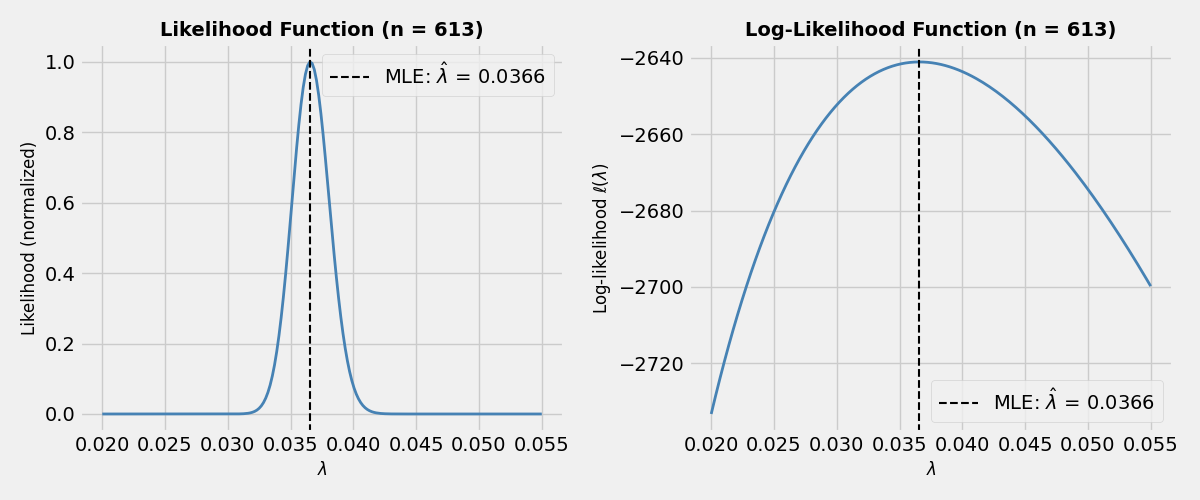

In [47]:
# Use the full dataset
lambda_hat = lambda_true  # MLE from full data

# Plot the likelihood function
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

lambda_grid = np.linspace(0.02, 0.055, 200)

# Compute log-likelihood values
loglik_values = np.array([log_likelihood_exp(lam, interarrivals) for lam in lambda_grid])

# Left: Likelihood (normalized so max = 1)
lik_values = np.exp(loglik_values - loglik_values.max())

axes[0].plot(lambda_grid, lik_values, color=COLOR_DATA, linewidth=2)
axes[0].axvline(lambda_hat, color=COLOR_TRUE, linestyle='--', linewidth=1.5,
                label=f'MLE: $\\hat{{\\lambda}}$ = {lambda_hat:.4f}')
axes[0].set_xlabel(r'$\lambda$', fontsize=12)
axes[0].set_ylabel('Likelihood (normalized)', fontsize=12)
axes[0].set_title(f'Likelihood Function (n = {n_full})', fontsize=14, fontweight='bold')
axes[0].legend()

# Right: Log-likelihood
axes[1].plot(lambda_grid, loglik_values, color=COLOR_DATA, linewidth=2)
axes[1].axvline(lambda_hat, color=COLOR_TRUE, linestyle='--', linewidth=1.5,
                label=f'MLE: $\\hat{{\\lambda}}$ = {lambda_hat:.4f}')
axes[1].set_xlabel(r'$\lambda$', fontsize=12)
axes[1].set_ylabel(r'Log-likelihood $\ell(\lambda)$', fontsize=12)
axes[1].set_title(f'Log-Likelihood Function (n = {n_full})', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

**Notice:** Does the shape of likelihood function look like anything to you? Remember this for later. What about the shape of the log-likelihood function?

### Interactive Demo: How the Likelihood Behaves

The likelihood function is random — it depends on the sample. Let's explore:
- How does it change from sample to sample?
- What happens as $n$ increases?
- Why does the MLE concentrate around the true value?

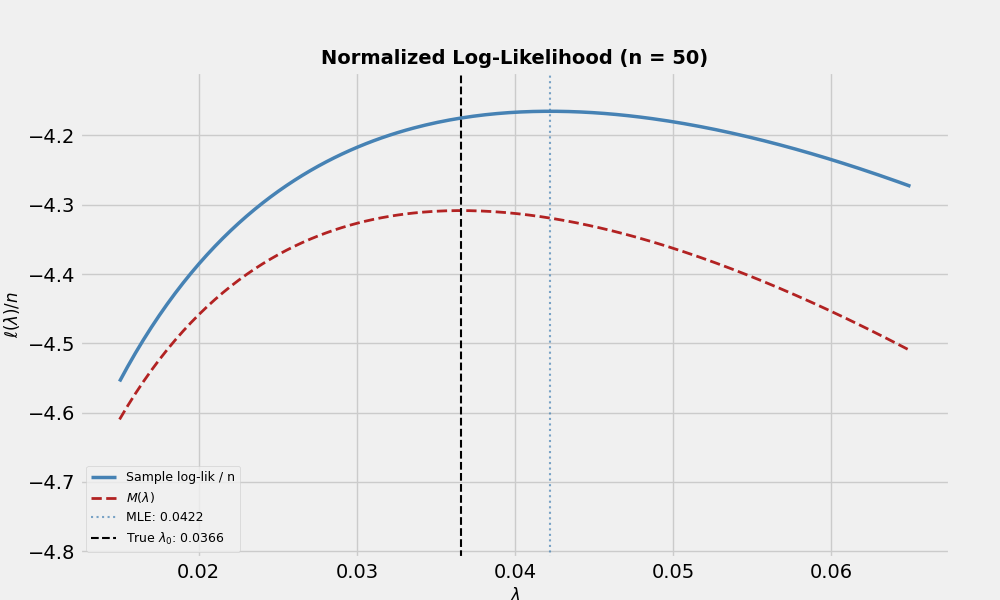

In [48]:
# Interactive likelihood demo
fig_demo, refresh_demo, demo_widgets = create_likelihood_demo(interarrivals, lambda_true)
display(demo_widgets)
refresh_demo()
plt.show()

### Observations from the Demo

1. **LLN at work:** As $n$ increases, the sample log-likelihood (divided by $n$) converges to its expectation.

2. **The expected log-likelihood is maximized at $\theta_0$:** The red dashed curve peaks at the true parameter value.

3. **The MLE concentrates:** For larger $n$, the MLE (blue dotted line) stays closer to the true value (black dashed line).

This is the essence of MLE consistency, but we haven't proven it yet.

---

## Why Maximum Likelihood?

### Heuristic Motivation

In Lecture 1, we saw that the MLE-based probability estimate had much lower variance than the empirical proportion. Why?

**Key insight:** The likelihood function contains all the information in the data that is relevant to distinguishing between distributions in our model.

- Two datasets with the same likelihood function (as a function of $\theta$) carry the same information about $\theta$.
- Maximizing the likelihood uses all of this information.

We'll see this more formally when we study Bayesian statistics: the likelihood is exactly what converts prior beliefs about $\theta$ into posterior beliefs.

**Caveat:** The likelihood only captures information relevant to *choosing among distributions in our model*. It doesn't help us assess whether the model itself is correct — that requires different tools (goodness-of-fit tests, which we'll see later).

### Definition: Maximum Likelihood Estimator

The **maximum likelihood estimator** (MLE) is:

$$\hat{\theta}_{\text{MLE}} = \arg\max_{\theta \in \Theta} \text{Lik}(\theta; X) = \arg\max_{\theta \in \Theta} \ell(\theta; X)$$

Since $\log$ is monotonic, maximizing likelihood is equivalent to maximizing log-likelihood.

---

## Consistency of the MLE

Why does the MLE converge to the true parameter value? The demo suggested an answer: the log-likelihood is close to its expectation, and that expectation is itself maximized at $\theta_0$.

### Setup

Let the true parameter be $\theta_0$. For any $\theta$, define:

$$M(\theta) = E_{\theta_0}[\log f_\theta(X)]$$

This is the expected log-likelihood (for one observation) when the truth is $\theta_0$ but we evaluate at $\theta$.

By the Law of Large Numbers:

$$\frac{1}{n}\ell(\theta; X) = \frac{1}{n}\sum_{i=1}^n \log f_\theta(X_i) \stackrel{P}{\to} M(\theta)$$

The MLE maximizes $\ell(\theta; X)/n$. If this function converges to $M(\theta)$, and $M(\theta)$ is maximized at $\theta_0$, then (heuristically) the MLE should converge to $\theta_0$.

### Key Claim: $M(\theta)$ is Maximized at $\theta_0$

**Theorem:** $M(\theta) \le M(\theta_0)$ for all $\theta$, with equality if and only if $f_\theta = f_{\theta_0}$.

**Proof:** We'll use **Jensen's inequality**: if $g$ is concave, then $E[g(Y)] \le g(E[Y])$.

Consider:
$$M(\theta) - M(\theta_0) = E_{\theta_0}\left[\log f_\theta(X) - \log f_{\theta_0}(X)\right] = E_{\theta_0}\left[\log \frac{f_\theta(X)}{f_{\theta_0}(X)}\right]$$

Since $\log$ is concave, Jensen's inequality gives:
$$E_{\theta_0}\left[\log \frac{f_\theta(X)}{f_{\theta_0}(X)}\right] \le \log E_{\theta_0}\left[\frac{f_\theta(X)}{f_{\theta_0}(X)}\right]$$

Now compute the expectation on the right:
$$E_{\theta_0}\left[\frac{f_\theta(X)}{f_{\theta_0}(X)}\right] = \int \frac{f_\theta(x)}{f_{\theta_0}(x)} f_{\theta_0}(x) dx = \int f_\theta(x) dx = 1$$

Therefore:
$$M(\theta) - M(\theta_0) \le \log(1) = 0$$

with equality only if $f_\theta(X)/f_{\theta_0}(X)$ is constant (deterministic), i.e., $f_\theta = f_{\theta_0}$. $\square$

### Caveat: This is Not Quite a Proof of Consistency

The argument above shows that *for each fixed $\theta$*, we have $\ell(\theta)/n \to M(\theta)$. This is **pointwise convergence**.

But the MLE involves maximizing over all $\theta$, which requires **uniform convergence**. The gap between pointwise and uniform convergence can cause problems in some settings. A complete proof requires additional technical conditions (which hold for exponential families and other "nice" models).

For this course, we'll work with models where consistency holds and not worry about the technicalities.

---

## The Score Function

To understand the MLE more deeply — especially its sampling distribution — we need to study the derivative of the log-likelihood.

### Motivation

The MLE $\hat{\theta}$ is (typically) found by setting the derivative of the log-likelihood to zero:

$$\frac{d}{d\theta} \ell(\theta; X) \bigg|_{\theta = \hat{\theta}} = 0$$

**Questions for you:**
1. Near the maximum, what sign does the *second* derivative have?
2. If the first derivative at $\theta_0$ is positive, is $\hat{\theta}$ larger or smaller than $\theta_0$?

These questions suggest that the first derivative at $\theta_0$ determines *how far* and *in which direction* the MLE deviates from the truth.

### Definition: The Score

The **score function** (or just **score**) is the derivative of the log-likelihood with respect to $\theta$:

$$S(\theta; X) = \ell_n'(\theta) = \frac{\partial}{\partial \theta} \ell_n(\theta)$$

For an i.i.d. model, let $\ell_1(\theta; X_i) = \log f_\theta(X_i)$ denote the log-likelihood contribution from a single observation. Then:

$$\ell_n(\theta) = \sum_{i=1}^n \ell_1(\theta; X_i)$$

and the score decomposes as:
$$S(\theta) = \ell_n'(\theta) = \sum_{i=1}^n \ell_1'(\theta; X_i)$$

The score is a sum of i.i.d. terms!

**Important:** We're differentiating with respect to $\theta$, not with respect to $X_i$. Even if $X_i$ is discrete, the score is well-defined as long as $f_\theta(x)$ is differentiable in $\theta$.

### Example 1: Exponential

For $X_i \sim \text{Exponential}(\lambda)$: $f_\lambda(x) = \lambda e^{-\lambda x}$

$$\ell_1(\lambda; X_i) = \log \lambda - \lambda X_i$$

$$\ell_1'(\lambda; X_i) = \frac{1}{\lambda} - X_i$$

For $n$ observations:
$$S(\lambda) = \ell_n'(\lambda) = \frac{n}{\lambda} - \sum_{i=1}^n X_i$$

Setting $S(\lambda) = 0$ gives $\hat{\lambda} = n / \sum X_i = 1/\bar{X}$, confirming our MLE.

### Example 2: Gaussian (known variance)

For $X_i \sim N(\mu, \sigma^2)$ with $\sigma^2$ known:

$$\ell_1(\mu; X_i) = -\frac{1}{2}\log(2\pi\sigma^2) - \frac{(X_i-\mu)^2}{2\sigma^2}$$

$$\ell_1'(\mu; X_i) = \frac{X_i - \mu}{\sigma^2}$$

### Example 3: Bernoulli

For $X_i \sim \text{Bernoulli}(p)$: $f_p(x) = p^x(1-p)^{1-x}$ for $x \in \{0, 1\}$

$$\ell_1(p; X_i) = X_i \log p + (1-X_i) \log(1-p)$$

$$\ell_1'(p; X_i) = \frac{X_i}{p} - \frac{1-X_i}{1-p} = \frac{X_i - p}{p(1-p)}$$

---

## Mean of the Score

A fundamental fact: **the score has mean zero at the true parameter value.**

**Theorem:** $E_{\theta}[\ell_1'(\theta; X_i)] = 0$

**Proof:** We can write:
$$\ell_1'(\theta; X_i) = \frac{\partial}{\partial\theta} \log f_\theta(X_i) = \frac{\frac{\partial}{\partial\theta} f_\theta(X_i)}{f_\theta(X_i)}$$

Taking the expectation (integrating over the distribution of $X_i$):
$$E_\theta[\ell_1'(\theta; X_i)] = \int \frac{\frac{\partial}{\partial\theta} f_\theta(x)}{f_\theta(x)} \cdot f_\theta(x) \, dx = \int \frac{\partial}{\partial\theta} f_\theta(x) \, dx$$

Now we interchange the derivative (with respect to $\theta$) and the integral (with respect to $x$):
$$\int \frac{\partial}{\partial\theta} f_\theta(x) \, dx = \frac{\partial}{\partial\theta} \int f_\theta(x) \, dx = \frac{\partial}{\partial\theta} (1) = 0 \quad \square$$

(The interchange is valid under regularity conditions that hold for "nice" models.)

**Verification for our examples:**
- **Exponential:** $E_\lambda[\ell_1'(\lambda; X_i)] = E_\lambda[1/\lambda - X_i] = 1/\lambda - 1/\lambda = 0$ ✓
- **Gaussian:** $E_\mu[\ell_1'(\mu; X_i)] = E_\mu[(X_i-\mu)/\sigma^2] = 0$ ✓
- **Bernoulli:** $E_p[\ell_1'(p; X_i)] = E_p[(X_i-p)/(p(1-p))] = 0$ ✓

---

## The Fisher Information

Since the score has mean zero, its variance is particularly important.

### Definition

The **Fisher information** in a single observation is:

$$I(\theta) = \text{Var}_\theta[\ell_1'(\theta; X_i)] = E_\theta[\ell_1'(\theta; X_i)^2]$$

(The second equality uses $E[\ell_1'] = 0$.)

For $n$ i.i.d. observations, the total Fisher information is $nI(\theta)$, since:
$$\text{Var}_\theta[S(\theta)] = \text{Var}_\theta\left[\sum_{i=1}^n \ell_1'(\theta; X_i)\right] = n \cdot \text{Var}_\theta[\ell_1'(\theta; X_i)] = nI(\theta)$$

### Why "Information"?

Intuitively, the Fisher information measures **how much the data tells us about $\theta$**:
- High $I(\theta)$ means $\ell_1'$ varies a lot → small changes in $\theta$ produce large changes in the likelihood → data is informative about $\theta$
- Low $I(\theta)$ means the likelihood is flat → data doesn't distinguish well between different $\theta$ values

We'll see this more precisely next lecture: the variance of the MLE is approximately $1/(nI(\theta))$.

### Fisher Information Examples

**Exponential:** $\ell_1'(\lambda; X_i) = 1/\lambda - X_i$, where $E[X_i] = 1/\lambda$, $\text{Var}(X_i) = 1/\lambda^2$

$$I(\lambda) = \text{Var}_\lambda\left(\frac{1}{\lambda} - X_i\right) = \text{Var}(X_i) = \frac{1}{\lambda^2}$$

**Gaussian:** $\ell_1'(\mu; X_i) = (X_i - \mu)/\sigma^2$

$$I(\mu) = \text{Var}_\mu\left(\frac{X_i - \mu}{\sigma^2}\right) = \frac{\text{Var}(X_i)}{\sigma^4} = \frac{\sigma^2}{\sigma^4} = \frac{1}{\sigma^2}$$

**Bernoulli:** $\ell_1'(p; X_i) = (X_i - p)/(p(1-p))$

$$I(p) = \text{Var}_p\left(\frac{X_i - p}{p(1-p)}\right) = \frac{\text{Var}(X_i)}{[p(1-p)]^2} = \frac{p(1-p)}{[p(1-p)]^2} = \frac{1}{p(1-p)}$$

**Pattern:** In all three cases, $I(\theta) = 1/\text{Var}_\theta(X_i)$. This is not a coincidence — it holds for one-parameter exponential families!

### An Alternative Formula

There's another way to compute Fisher information that's often more convenient.

**Theorem:** $I(\theta) = -E_\theta[\ell_1''(\theta; X_i)]$

**Proof:** We showed that $E_\theta[\ell_1'(\theta; X_i)] = 0$ for all $\theta$. Differentiate both sides with respect to $\theta$:

$$0 = \frac{\partial}{\partial\theta} E_\theta[\ell_1'(\theta; X_i)] = \frac{\partial}{\partial\theta} \int \ell_1'(\theta; x) f_\theta(x) \, dx$$

Using the product rule (and interchanging derivative and integral):
$$0 = \int \ell_1''(\theta; x) \cdot f_\theta(x) \, dx + \int \ell_1'(\theta; x) \cdot \frac{\partial}{\partial\theta} f_\theta(x) \, dx$$

The first integral is $E_\theta[\ell_1''(\theta; X_i)]$. For the second, note that $\frac{\partial}{\partial\theta} f_\theta(x) = \ell_1'(\theta; x) \cdot f_\theta(x)$, so:
$$\int \ell_1'(\theta; x) \cdot \frac{\partial}{\partial\theta} f_\theta(x) \, dx = \int \ell_1'(\theta; x)^2 f_\theta(x) \, dx = E_\theta[\ell_1'(\theta; X_i)^2] = I(\theta)$$

Therefore: $0 = E_\theta[\ell_1''(\theta; X_i)] + I(\theta)$, giving $I(\theta) = -E_\theta[\ell_1''(\theta; X_i)]$. $\square$

**Interpretation:** The Fisher information equals the negative expected curvature of the log-likelihood. More curvature at the maximum means the MLE is more precisely determined.

---

## Preview: Why Fisher Information Determines MLE Variance

We'll prove this rigorously next lecture, but here's the intuition.

Near the true value $\theta_0$, Taylor expand the score:
$$0 = S(\hat{\theta}) \approx S(\theta_0) + (\hat{\theta} - \theta_0) \ell_n''(\theta_0)$$

Solving for $\hat{\theta} - \theta_0$:
$$\hat{\theta} - \theta_0 \approx -\frac{S(\theta_0)}{\ell_n''(\theta_0)}$$

The numerator $S(\theta_0) = \sum_{i=1}^n \ell_1'(\theta_0; X_i)$ is a sum of mean-zero i.i.d. terms with variance $nI(\theta_0)$.

The denominator $\ell_n''(\theta_0) = \sum_{i=1}^n \ell_1''(\theta_0; X_i) \approx -nI(\theta_0)$ by LLN (since $E[\ell_1''] = -I$).

So:
$$\hat{\theta} - \theta_0 \approx \frac{S(\theta_0)}{nI(\theta_0)} \approx N\left(0, \frac{1}{nI(\theta_0)}\right)$$

**The variance of the MLE is approximately $1/(nI(\theta_0))$** — inversely proportional to Fisher information.

---

## Summary

### The Big Picture

| Probability | Statistics |
|------------|------------|
| Distribution → Data | Data → Distribution |
| $\theta$ known | $\theta$ unknown |
| Compute probabilities | Make inferences |

**The analyst's perspective** — what we know and don't know — shapes everything.

### Key Concepts

1. **Statistical model**: Set of candidate distributions (parametric vs. nonparametric)

2. **Estimators**: Functions of data that guess parameter values
   - Consistent: converges to truth
   - Asymptotically normal: approximately Gaussian for large $n$

3. **Likelihood function**: $\text{Lik}(\theta) = \prod f_\theta(X_i)$ — carries all information about $\theta$

4. **MLE consistency**: Expected log-likelihood maximized at true $\theta$ (Jensen)

5. **Score**: $S(\theta) = \ell_n'(\theta)$ — has mean zero at $\theta_0$

6. **Fisher information**: $I(\theta) = \text{Var}[\ell_1'(\theta; X_i)] = -E[\ell_1''(\theta; X_i)]$

### Next Lecture

- Prove the MLE is asymptotically normal with variance $1/(nI(\theta))$
- Confidence intervals from the MLE
- What does it mean to be "efficient"?